# ДЗ №2

Сделать логистическую регрессию на известных признаках, получить как можно лучший `score` (использовать регулиризацию, подбор гиперпараметров)

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
sns.set()

from math import floor

In [55]:
def cross_validation(train, features, target, scoring_metric='roc_auc', l1=None, solver='lbfgs', penalty='l2', needPrint=True):
    cv_results = cross_val_score(LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1), train[features], train[target].values.ravel(), cv=5, scoring=scoring_metric)
    
    score = np.mean(cv_results)
    if needPrint:
        print( f'Average = {score}')
    
    return score

In [56]:
def train_and_save_model(train, test, features, target, nameFile, l1=None, solver='lbfgs', penalty='l2'):
    model = LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1)
    model.fit(X=train[features], y = train[target].values.ravel())
    test_prediction = model.predict_proba(test[features])[:,1]
    sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
    sample_submission[target] = test_prediction
    sample_submission.to_csv(f'HW#2_models/{nameFile}.csv', index = False)

In [57]:
def normalize(sequences):
    return (sequences - sequences.mean()) / (sequences.max() - sequences.min())

In [58]:
train = pd.read_csv('../data/raw/application_train.csv')
test = pd.read_csv('../data/raw/application_test.csv')

### Модель 0

In [59]:
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']
target = ['TARGET']

In [60]:
train['AMT_ANNUITY'] = train['AMT_ANNUITY'].fillna(train['AMT_ANNUITY'].median())
test['AMT_ANNUITY'] = test['AMT_ANNUITY'].fillna(train['AMT_ANNUITY'].median())

In [61]:
train[features] /= 1000
test[features] /= 1000

In [62]:
score_cross_val0 = cross_validation(train, features, target)

Average = 0.5327320455583101


In [63]:
train_and_save_model(train, test, features, target, 'model_0')

### Модель 1
Нормализуем данные

In [64]:
train1 = train.copy()
test1 = test.copy()

In [65]:
train1[features] = normalize(train1[features])
test1[features] = normalize(test1[features])

In [66]:
score_cross_val1 = cross_validation(train1, features, target)

Average = 0.5301784448570589


In [67]:
train_and_save_model(train1, test1, features, target, 'model_1')

### Модель 2
Добавим категориальные признаки

In [68]:
features += ['CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR',
             'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE']

In [69]:
train['CODE_GENDER'] = train['CODE_GENDER'].replace( { 'M':1,'F':0, 'XNA': 0  })
test['CODE_GENDER'] = test['CODE_GENDER'].replace( { 'M':1,'F':0, 'XNA': 0  })

In [70]:
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace( { 'Y':1,'N':0  })
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].replace( { 'Y':1,'N':0  })

In [71]:
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace( { 'Y':1,'N':0  })
test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].replace( { 'Y':1,'N':0  })

In [72]:
dict_education = {'Secondary / secondary special': 1, 'Higher education': 3,
       'Incomplete higher': 2, 'Lower secondary': 0, 'Academic degree': 4}
train['NAME_EDUCATION_TYPE'] = train['NAME_EDUCATION_TYPE'].replace(dict_education)
test['NAME_EDUCATION_TYPE'] = test['NAME_EDUCATION_TYPE'].replace(dict_education)

In [73]:
dict_family_stat = {'Single / not married': 0, 'Married': 2, 'Civil marriage': 1, 'Widow': 4,
       'Separated': 3, 'Unknown': 0 }
train['NAME_FAMILY_STATUS'] = train['NAME_FAMILY_STATUS'].replace(dict_family_stat)
test['NAME_FAMILY_STATUS'] = test['NAME_FAMILY_STATUS'].replace(dict_family_stat)

In [74]:
dict_income_type = {'Working': 3, 'State servant': 5, 'Commercial associate': 6, 'Pensioner': 7,
       'Unemployed': 0, 'Student': 1, 'Businessman': 4, 'Maternity leave': 2}
train['NAME_INCOME_TYPE'] = train['NAME_INCOME_TYPE'].replace(dict_income_type)
test['NAME_INCOME_TYPE'] = test['NAME_INCOME_TYPE'].replace(dict_income_type)

In [75]:
train[features] = normalize(train[features])
test[features] = normalize(test[features])

In [76]:
score_cross_val2 = cross_validation(train, features, target)

Average = 0.6128664921664913


In [77]:
train_and_save_model(train, test, features, target, 'model_2')

### Модель 3
Применим формулы для категориальных признаков

#HELP почему-то функция `proc_categories` выдает nan значения

In [78]:
def proc_categories(train, test, column_name):
    K = train.groupby([column_name]).size()
    mean_y = train.groupby([column_name])[column_name].mean()
    global_mean_y = train[column_name].mean()
    train[column_name] = (mean_y * K + global_mean_y * 10) / (K + 10)
    test[column_name] = (mean_y * K + global_mean_y * 10) / (K + 10)
    
    return train, test

In [79]:
# train, test = proc_categories(train, test, 'NAME_EDUCATION_TYPE')
# train, test = proc_categories(train, test, 'NAME_INCOME_TYPE')

In [80]:
# score_cross_val3 = cross_validation(train, features, target)

In [81]:
# train_and_save_model(train, test, features, target, 'model_3')

### Модель 4
добавим datetime признаки

In [82]:
features += ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']

In [83]:
train['DAYS_REGISTRATION'] = train['DAYS_REGISTRATION'] / 365
train['DAYS_ID_PUBLISH'] = train['DAYS_ID_PUBLISH'] / 365
train['DAYS_BIRTH'] = train['DAYS_REGISTRATION'] / 365

In [84]:
train[features] = normalize(train[features])
test[features] = normalize(test[features])

In [85]:
score_cross_val4 = cross_validation(train, features, target)

Average = 0.6271887889701484


In [86]:
train_and_save_model(train, test, features, target, 'model_4')

### Модель 5
Попробуем подобрать оптимальные гиперпараметры для нашей модели

In [87]:
features

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'CODE_GENDER',
 'FLAG_OWN_REALTY',
 'FLAG_OWN_CAR',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_INCOME_TYPE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_BIRTH']

In [88]:
train[features] = normalize(train[features])
test[features] = normalize(test[features])

In [89]:
l1_best = 0.1
max_score = 0.0
for i in range (10):
    res = cross_validation(train, features, target, l1=0.1 * i, solver='saga', penalty='elasticnet', needPrint=False)
    print(f'Score = {res}, l1 = {0.1 * i}')
    if (res > max_score):
        max_score = res
        l1_best = 0.1 * i
        
print(f'\nMax Score = {max_score}, l1 = {l1_best}')
score_cross_val5 = max_score

Score = 0.6271704234141151, l1 = 0.0
Score = 0.6271722302684163, l1 = 0.1
Score = 0.6271744460870239, l1 = 0.2
Score = 0.6271773665492341, l1 = 0.30000000000000004
Score = 0.6271796364953458, l1 = 0.4
Score = 0.6271829609067049, l1 = 0.5
Score = 0.6271879724567335, l1 = 0.6000000000000001
Score = 0.627191489236224, l1 = 0.7000000000000001
Score = 0.627191138686275, l1 = 0.8
Score = 0.6271913930382016, l1 = 0.9

Max Score = 0.627191489236224, l1 = 0.7000000000000001


In [90]:
train_and_save_model(train, test, features, target, 'model_5', l1=l1_best, solver='saga', penalty='elasticnet')

### Итоги
Модели:

0. Score(private) - 0.53786, Score(public) - 0.55338, cv - 0.53273
1. Score(private) - 0.51821, Score(public) - 0.53444, cv - 0.53017
2. Score(private) - 0.61634, Score(public) - 0.61430, cv - 0.61286
3. -
4. Score(private) - 0.63189, Score(public) - 0.63142, cv - 0.62718
5. Score(private) - 0.63189, Score(public) - 0.63143, cv - 0.62719

No handles with labels found to put in legend.


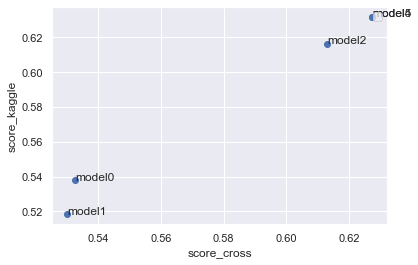

In [91]:
df = pd.DataFrame()
df['score_cross_val'] = [score_cross_val0, score_cross_val1, score_cross_val2, score_cross_val4, score_cross_val5]
df['score_kaggle'] = [0.53786, 0.51821, 0.61634, 0.63189, 0.63189]
df['model'] = ['model0', 'model1', 'model2', 'model4', 'model5']

fig, ax = plt.subplots()
ax.scatter(df['score_cross_val'], df['score_kaggle'])

for i, txt in enumerate(df['model']):
    ax.annotate(txt, (df['score_cross_val'][i], df['score_kaggle'][i]))

plt.xlabel('score_cross')
plt.ylabel('score_kaggle')
plt.legend()
plt.show()

### Вывод
Самой лучшей моделью оказалась модель №5 с нормированными параметрами и настроенными гиперпараметрами. Cross-validation была правильно настроена, так как показывает схожие результаты с kaggle. С помощью регуляризации и изменения гиперпараметров незначительно улучшился score на public данных kaggle. 